# Imports

In [1]:
import numpy as np
import pandas as pd
from typing import Tuple, Dict
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import defaultdict

# Intensities

In [2]:
class IntensityTable:
    """
        Stores order-flow intensities λ^type(depth, queue_size) for Model I.
        Depth = distance (in ticks) from reference price to that limit.
        Queue_size = normalized queue length (e.g. in units of AES).

        Internally caps both dimensions to finite maxima for tractability.
    """
    def __init__(
        self,
        max_depth: int,
        max_queue: int,
        types: Tuple[str, ...] = ("limit", "cancel", "market"),
    ):
        self.max_depth = max_depth # max depth of LOB (in ticks)
        self.max_queue = max_queue # max queue size of LOB (in units of AES)
        self.types = types         # types of order flow (limit, cancel, market)
        self._data = np.zeros((max_depth, max_queue + 1, len(types))) # (depth, queue_size, type)
        self._type_index: Dict[str, int] = {t: i for i, t in enumerate(types)} # type -> index

    def set_intensity(
        self,
        depth: int,        # 1 = best price depth, 2 = second best, etc.
        queue: int,        # 0 = empty queue, 1 = one AES unit, etc.
        type_name: str,    # type of order flow (limit, cancel, market)
        value: float,      # intensity value (λ^type(depth, queue_size))
    ) -> None:
        
        """
            Sets intensity for given type, depth, and queue size.
        """
        d = min(depth, self.max_depth) - 1
        q = min(queue, self.max_queue)
        ti = self._type_index[type_name] # type -> index
        self._data[d, q, ti] = value

    def get_intensities(
        self,
        depth: int,
        queue: int,
    ) -> Dict[str, float]:
    
        """
            Returns intensities for all types at given depth and queue size.
        """
        d = min(depth, self.max_depth) - 1
        q = min(queue, self.max_queue)
        raw = self._data[d, q, :]
        return {t: raw[self._type_index[t]] for t in self.types}

    # def to_dataframe(self) -> pd.DataFrame:
    #     rows, index = [], []
    #     for d in range(1, self.max_depth + 1):
    #         for q in range(0, self.max_queue + 1):
    #             index.append((d, q))
    #             rows.append(self._data[d-1, q, :].tolist())
    #     mi = pd.MultiIndex.from_tuples(index, names=["depth", "queue_size"])
    #     return pd.DataFrame(rows, index=mi, columns=list(self.types))

In [3]:
# Example usage of IntensityTable class:
MAX_DEPTH = 5
MAX_QUEUE = 50
int_table = IntensityTable(MAX_DEPTH, MAX_QUEUE)
# Fill int_table.set_intensity(depth, queue, type, value) with data 

In [4]:
def compute_invariant_distribution(
        intensity_table: IntensityTable,
        dump_path: str = "invariant_distribution.npy"
    ) -> None:
    """
        Precompute and store the invariant distributions π_i(n) for each queue depth i (Section 2.3.3.) in an array.

    Inputs:
        - intensity_table: IntensityTable object with order-flow intensities.
        - Q: maximum queue size (in units of AES)
        dump_path: path to save the precomputed distribution (NumPy array)

    Outputs:
        - None. Saves the invariant distributions to a file.
    """
    intensities = intensity_table._data
    K, Q_plus_1, _ = intensities.shape            # max depth, max queue size + 1, number of types
    Q = Q_plus_1 - 1                              # max queue size (in units of AES)
    type_to_index = intensity_table._type_index   # type -> index
    all_pi = np.zeros((K, Q + 1))                 # invariant distribution for each depth (bid-ask symmetry)

    for i in range(K):

        # Arrival/departure ration vector $\rho_i$ (Section 2.3.3.)
        lamL = intensities[i][:-1, type_to_index['limit']]
        lamC = intensities[i][1:, type_to_index['cancel']]
        lamM = intensities[i][1:, type_to_index['market']]
        rho =  lamL / (lamC + lamM + 1e-6)

        pi = np.zeros(Q+1)
        pi_0 = 1 / (1 + np.sum(np.cumprod(rho)))
        pi[1:] = pi_0 * np.cumprod(rho)
        pi /= np.sum(pi)  # Normalize to sum to 
        all_pi[i] = pi

    np.save(dump_path, all_pi)

In [5]:
def sample_stationary_lob_from_file(
        distribution_file: str, 
        rng: np.random.Generator, 
        depths: list = None
    ) -> np.ndarray:

    """
        Sample queue sizes from the invariant distribution (Section 2.3.3.).

    Inputs:
        - distribution_file: path to .npy file with invariant distribution with shape (K, Q+1)
        - rng: np.random.Generator for reproducibility
        - depths: optional list of depths to sample (1-indexed).
                If None, sample the entire LOB.

    Outputs:
        - If depths is None: array of shape (2K,) → [q_bid1,…,q_bidK, q_ask1,…,q_askK]
        - Else: array of shape (len(depths),) with sampled queue sizes targeting the given depths.
    """

    all_pi = np.load(distribution_file)
    K, Q_plus_1 = all_pi.shape

    if depths is None:
        # >>> FULL LOB SAMPLING
        state = np.zeros(2 * K, dtype=int)
        for i in range(K):
            probs = all_pi[i]
            level = rng.choice(np.arange(Q_plus_1), p=probs)
            state[i] = level       # q_bid(i+1)
            level = rng.choice(np.arange(Q_plus_1), p=probs)
            state[K + i] = level   # q_ask(i+1)

        return state

    else:
        # >>> PARTIAL SAMPLING
        sampled = []
        for d in depths:
            if not (1 <= d <= K):
                raise ValueError(f"Depth {d} out of bounds: must be in 1,…,{K}")
            probs = all_pi[d - 1]
            sampled.append(rng.choice(np.arange(Q_plus_1), p=probs))

        return np.array(sampled, dtype=int)

# Model I

In [6]:
def simulate_model_I(
    current_LOB: pd.DataFrame,
    intensity_table: IntensityTable,
    tick: float,
    theta: float,
    theta_reinit: float,
    max_steps: int = None,
    time_end: float = None,
    random_seed: int = None 
) -> Tuple[pd.DataFrame, bool, int]:
    """
        Runs Model I (Section 2.3.1) simulation with optional reproducible RNG.
        The reference price p_ref is fixed.
        Simulation stops either on (max_steps or time_end) or mid-price move (p_ref changes).

    Inputs:
        - current_LOB: DataFrame with the LOB up to time t=initial_time.
        - intensity_table: IntensityTable object with order-flow intensities.
        - tick: tick size 
        - theta: probability of p_ref change after p_mid change (Section 3.1.1.)
        - theta_reinit: probability of redrawing LOB from invariant distribution after p_ref change (Section 3.1.1.)
        - max_steps: maximum number of steps to simulate (optional).
        - time_end: end time for simulation (optional).
        - random_seed: seed for RNG (optional).

    Outputs:
        - Dataframe of updated LOB ('time', 'p_mid', 'p_ref', 'side', 'depth', 'event', 'queue_size', 'q_bidK', ..., 'q_bid1', 'q_ask1', ..., 'q_askK')
        - mid_termination: boolean indicating if simulation ended because of mid-price move.
        - step: number of new events in the LOB.
    """
    Q = intensity_table.max_queue  # max queue size of LOB (in units of AES)
    K = intensity_table.max_depth   # max depth of LOB (in ticks)
    last_row = current_LOB.iloc[-1] # last update of the LOB

    # Prices
    p_mid = last_row['p_mid']
    p_ref = last_row['p_ref']

    # Current state of the LOB in the format [q_bid1, ..., q_bidK, q_ask1, ..., q_askK] (in AES units)
    columns = [f'q_bid{i+1}' for i in range(K)] + [f'q_ask{i+1}' for i in range(K)]
    state = last_row[columns].values.copy().astype(int)

    # Initialize RNG for reproducibility
    rng = np.random.default_rng(random_seed)

    # Find best depths
    best_bid = next((i for i in range(K) if state[i] > 0), None)
    assert (best_bid is not None)
    best_ask = next((j for j in range(K) if state[K + j] > 0), None)
    assert (best_ask is not None)

    records = []
    t = last_row['time'] # initial time of simulation is time of last update
    step = 0

    mid_termination = False # end simulation because of mid price change
    mid_price = p_mid
    ref_price = p_ref

    while True:
        # max steps
        if max_steps is not None and step >= max_steps:
            break
        
        ## Simulation of timestamp of next event, event type and depth
        # Intensities for each event type (limit, cancel, market) at each depth (bid/ask)
        rates = []
        for side in ['bid', 'ask']:
            for d in range(1, K+1):
                idx = (d-1) if side=='bid' else (K + d-1)
                qsize = state[idx]
                ints = intensity_table.get_intensities(d, qsize)
                rates.append((ints['limit'],  side, d, 'limit'))
                rates.append((ints['cancel'], side, d, 'cancel'))
                rates.append((ints['market'], side, d, 'market'))

        total_rate = sum(r for r, *_ in rates)
        if total_rate <= 0:
            raise ValueError(f"Total_rate <= 0 at step {step}, t={t:.4f}, stopping simulation")

        # Inter-event time
        delta_t = rng.exponential(1/total_rate)
        t += delta_t
        if time_end is not None and t > time_end:
          break

        # Determine event type and depth
        r = rng.random() * total_rate
        cum = 0.0
        for rate, side, depth, ev in rates:
            cum += rate
            if r <= cum:
                chosen = (side, depth, ev)
                break
        
        # Update state of the LOB
        side, depth, ev = chosen 
        idx = (depth-1) if side=='bid' else (K + depth-1)
        if ev == 'limit':
            state[idx] = min(state[idx] + 1, Q) # add limit order
        else: # ev == 'cancel' or 'market'
            if state[idx] > 0:
                state[idx] -= 1

        new_best_bid = next((i for i in range(K) if state[i] > 0), None)
        assert (best_bid is not None)
        new_best_ask = next((j for j in range(K) if state[K + j] > 0), None)
        assert (best_bid is not None)

      
        if new_best_bid != best_bid or new_best_ask != best_ask:
          # mid price change
          change_p_ref = rng.random() # probability of p_ref change after p_mid change
          ext_info = rng.random()     # probability of redrawing LOB from invariant distribution after p_ref change
          mid_termination = True
          mid_price = 0.5 * ((ref_price + tick*(new_best_ask+0.5)) + (ref_price - tick*(new_best_bid+0.5)))
          delta_tick = 2*(mid_price - p_mid) / tick # if p_ref changes, if moves of delta_tick ???? ticks (how many ticks?)
        
          if np.abs(np.abs(delta_tick) - np.abs(round(delta_tick))) > 1e-2:
            raise ValueError('Unexpected delta_tick value. It should be 1 or -1.')
          
          if change_p_ref < theta:   # p_ref changes
            ref_price += tick * delta_tick / np.abs(delta_tick)
            delta_tick = 1
            old_state = state.copy()

            if ext_info > theta_reinit: # no external information (Section 3.1.1)
              if mid_price < p_mid: # price went down
                # update ask
                state[K:K+delta_tick] = 0
                state[K+delta_tick:] = old_state[K:2*K-delta_tick]
                # update bid 
                state[:K-delta_tick] = old_state[delta_tick:K]
                depths =[i+1 for i in range(K-delta_tick, K)]
                state[K-delta_tick:] = sample_stationary_lob_from_file("invariant_distribution.npy", rng, depths=depths)
            
              else: # price went up 
                # update bid
                state[:delta_tick] = 0
                state[delta_tick:K] = old_state[:K-delta_tick]
                # update ask 
                state[K:2*K-delta_tick] = old_state[K+delta_tick:]
                depths =[i+1 for i in range(K-delta_tick, K)]
                state[2*K-delta_tick:] = sample_stationary_lob_from_file("invariant_distribution.npy", rng, depths=depths)
                
            else: # exogenous information: redraw from invariant distribution (Section 3.1.1)
                state = sample_stationary_lob_from_file("invariant_distribution.npy", rng)  
            
            # update mid price
            new_best_bid = next((i for i in range(K) if state[i] > 0), None)
            assert (best_bid is not None)
            new_best_ask = next((j for j in range(K) if state[K + j] > 0), None)
            assert (best_bid is not None)
            mid_price = 0.5 * ((ref_price + tick*(new_best_ask+0.5)) + (ref_price - tick*(new_best_bid+0.5)))
          
        # Record event + full LOB snapshot
        rec = {'time': t, 
               'p_mid': round(2*mid_price/tick) * tick / 2, 
               'p_ref': round(2*ref_price/tick) * tick / 2,
               'side': side,
               'depth': depth, 
               'event': ev,
               'queue_size': state[idx]}

        for j in range(K):
            rec[f'q_bid{j+1}'] = state[j]
        for j in range(K):
            rec[f'q_ask{j+1}'] = state[K+j]

        records.append(rec)
        step += 1

        # 3) stop on mid-price move
        if mid_termination:
            print('Simulation ended because of price move')
            break
      
    assert (len(records) > 0)
    new_events_LOB = pd.DataFrame(records)
    updated_LOB = pd.concat([current_LOB, new_events_LOB], ignore_index=True)

    return updated_LOB, mid_termination, step

# Model III

## Normal

In [7]:
def simulate_model_III(
    current_LOB: pd.DataFrame,
    intensity_table: IntensityTable,
    tick: float,
    theta: float,
    theta_reinit: float,
    time_end: float,
    seed_base: int = 0
) -> Tuple[pd.DataFrame, Dict[str, int]]:
    
    """
        Simulates Model III (Section 3.1.1.) until time_end.
        We repeat the following until time_end: 
            - run Model I (Section 2.3.1.) until the mid-price changes, 
            - update the LOB (Section 3.1.1.)

    Inputs:
        - current_LOB: DataFrame with the LOB up to time t=initial_time.
        - intensity_table: IntensityTable object with order-flow intensities.
        - tick: tick size
        - theta: probability of p_ref change after p_mid change (Section 3.1.1.)
        - theta_reinit: probability of redrawing LOB from invariant distribution after p_ref change (Section 3.1.1.)
        - time_end: end time for simulation.
        - seed_base: seed for RNG (optional).
    
    Outputs:
        - Dataframe of updated LOB ('time', 'p_mid', 'p_ref', 'side', 'depth', 'event', 'queue_size', 'q_bidK', ..., 'q_bid1', 'q_ask1', ..., 'q_askK')
        - nb_events_dic: dictionary with the number of events in each type of simulation.
    """

    nb_events_dic = {'price_change': [], 'time_limit': []} # tracks the number of events in each type of simulation

    LOB = current_LOB.copy()
    step = 0

    ### SIMULATION of Model I (Section 2.3.1) on [initial_time, time_end[

    # Either the simulation ends on time limit or mid-price move
    # If it ends on price move, we resimulate again till the end of the time interval

    mid_termination = True # simulation ended because of mid price change
    while mid_termination: # resimulate until time limit

        new_LOB, mid_termination, nb_events = simulate_model_I(
            current_LOB=LOB,
            intensity_table=intensity_table,
            tick=tick,
            theta=theta,
            theta_reinit=theta_reinit,
            max_steps=None,
            time_end=time_end,
            random_seed=seed_base+step)
        
        if mid_termination:
            nb_events_dic['price_change'].append((step, nb_events))
        else:
            nb_events_dic['time_limit'].append((step, nb_events))

        step += 1
        LOB = new_LOB.copy()
 
    return LOB, nb_events_dic


## With Trader

In [8]:
def simulate_with_trader(
    current_LOB: pd.DataFrame,
    intensity_table: IntensityTable,
    tick: float,
    theta: float,
    theta_reinit: float,
    T: float,
    n: int,
    trader_orders: list[Tuple[str, int]],  # list of (side, quantity)
    seed_base: int = 0
) -> Tuple[pd.DataFrame, Dict[str, int]]:
    
    """
        Simulates Model III (Section 3.1.1.) until time_end with actions of a trader.
        The trader can intervene at times t_1, ...t_n=T.
        We repeat the following on each [t_i, t_{i+1}[ until time_end: 
            - run Model I (Section 2.3.1.),
            - trader action (market order), 
            - update the LOB (Section 3.1.1.)

    Inputs:
        - current_LOB: DataFrame with the LOB up to time t=initial_time.
        - intensity_table: IntensityTable object with order-flow intensities.
        - tick: tick size
        - theta: probability of p_ref change after p_mid change (Section 3.1.1.)
        - theta_reinit: probability of redrawing LOB from invariant distribution after p_ref change (Section 3.1.1.)
        - time_end: end time for simulation.
        - seed_base: seed for RNG (optional).
    
    Outputs:
        - Dataframe of updated LOB ('time', 'p_mid', 'p_ref', 'side', 'depth', 'event', 'queue_size', 'q_bidK', ..., 'q_bid1', 'q_ask1', ..., 'q_askK')
        - nb_events_dic: dictionary with the number of events in each type of simulation.
    """
    Q = intensity_table.max_queue     # max queue size of LOB (in units of AES)
    K = intensity_table.max_depth     # max depth of LOB (in ticks)
    last_row = current_LOB.iloc[-1]   # last update of the LOB
    p_mid = last_row['p_mid']         # mid price
    p_ref = last_row['p_ref']         # reference price
    times = np.linspace(0, T, n + 1)  # trading times [t1, ..., tn=T]
    
    nb_events_dic = {'price_change': [], 'time_limit': []} # tracks the number of events in each type of simulation

    LOB = current_LOB.copy()
    step = 0

    for i in range(n):
        t_end = times[i + 1]

        ### 1) SIMULATION of Model I (Section 2.3.1) on [t_start, t_end[
    
        # Either the simulation ends on time limit or mid-price move
        # If it ends on price move, we resimulate again till the end of the time interval
        mid_termination = True # simulation ended because of mid price change
        while mid_termination: # resimulate until time limit

            new_LOB, mid_termination, nb_events = simulate_model_I(
                current_LOB=LOB,
                intensity_table=intensity_table,
                tick=tick,
                theta=theta,
                theta_reinit=theta_reinit,
                max_steps=None,
                time_end=t_end,
                random_seed=seed_base+step)
            
            if mid_termination:
                nb_events_dic['price_change'].append((step, nb_events))
            else:
                nb_events_dic['time_limit'].append((step, nb_events))
    
            step += 1
            LOB = new_LOB.copy()

        # Current state of the LOB in the format [q_bid1, ..., q_bidK, q_ask1, ..., q_askK] (in AES units)
        last_row = LOB.iloc[-1]
        columns = [f'q_bid{i+1}' for i in range(K)] + [f'q_ask{i+1}' for i in range(K)]
        state = last_row[columns].values.copy().astype(int)


        ### 2) TRADER ACTION at t=t_end
        side, quantity = trader_orders[i]
        assert side in ('bid', 'ask')
        updated_state = state.copy()

        if side == 'ask': # buy market order
            ask_volumes = updated_state[K:]  # q_ask1 to q_askK
            if ask_volumes.sum() <= quantity:
                raise ValueError("Not enough liquidity to buy the requested quantity.")
            qty_left = quantity
            # trader consumes available liquidity
            for depth in range(K):
                available = ask_volumes[depth]
                take = min(available, qty_left)
                updated_state[K + depth] -= take
                qty_left -= take
                # index of new best ask
                if qty_left == 0 and updated_state[K + depth] == 0:
                    idx = K + depth + 1
                    break
                elif qty_left == 0:
                    break

        elif side == 'bid': # sell market order
            bid_volumes = updated_state[:K]  # q_bid1 to q_bidK
            if bid_volumes.sum() <= quantity:
                raise ValueError("Not enough liquidity to buy the requested quantity.")
            qty_left = quantity
            # trader consumes available liquidity
            for depth in range(K):
                available = bid_volumes[depth]
                take = min(available, qty_left)
                updated_state[depth] -= take
                qty_left -= take
                # index of new best bid
                if qty_left == 0 and updated_state[depth] == 0:
                    idx = depth + 1
                    break
                elif qty_left == 0:
                    idx = depth
                    break

        ### 3) UPDATE LOB with trader action
        # Update the mid price and reference price
        if side == 'ask':
            mid_price = p_mid + tick * (depth + 1) * 0.5
        else:
            mid_price = p_mid - tick * (depth + 1) * 0.5

        if mid_price != p_mid: # mid price changed
            # Update the reference price
            if mid_price % tick != 0: # mid price is not a multiple of tick
                ref_price = mid_price
            else:
                candidates = [mid_price - 0.5 * tick, mid_price + 0.5 * tick]
                ref_price = min(candidates, key=lambda x: abs(x - p_ref))
            # Update the state
            old_state = updated_state.copy()
            ### COMPLETE HERE: WHAT DO WE DO ? IS THE UPDATE PURELY DETERMINISTIC OR NOT ?
            # updated_state = ...


        # Record event + full LOB snapshot
        record = {
            'time': t_end,
            'p_mid': mid_price,
            'p_ref': ref_price,
            'side': side,
            'depth': depth+1,
            'event': 'trader_action',
            'queue_size': updated_state[idx]}
        
        for j in range(K):
            record[f'q_bid{j+1}'] = updated_state[j]
        for j in range(K):
            record[f'q_ask{j+1}'] = updated_state[K + j]

        trader_event = pd.DataFrame([record])
        LOB = pd.concat([LOB, trader_event], ignore_index=True)
    
    return LOB, nb_events_dic


# Calibration

DATA CALIBRATION METHOD:

BE VIGILANT WITH TRADE THROUGHS

What must be calibrated are:
    - AES per depth
    - Intensities
    - Parameters theta and theta_reinit

QRM Paper:
    - Remove first and last hour of trading
    - 

In [9]:
# this code only works in the case where spread is one tick ?? to check !!
def estimate_intensities(messages: pd.DataFrame, orderbook: pd.DataFrame, 
                         depth: int, AES: float, max_queue_size: int = 50):
    """
    Estimate (lambda^L, lambda^C, lambda^M) for queue Q_i using LOBSTER data.
    Note: this aggregates Q_i and Q_{-i} (see Section 2.3.2)

    Parameters:
    - messages: DataFrame with columns [time, type, order_id, size, price, direction]
    - orderbook: DataFrame with columns [ask_price_1, ask_size_1, bid_price_1, bid_size_1, …]
    - depth: which queue depth i (1-indexed)
    - AES: average event size at Q_i (in shares)
    - max_queue_size: cap on queue size buckets

    Returns:
    - intensity_table: dict of the form:
      {
        n: { 'limit': λ^L_i(n), 'cancel': λ^C_i(n), 'market': λ^M_i(n) }
      }
    """

    # Choose the correct side and column based on depth
    bid_col = f"bid_size_{depth}"
    ask_col = f"ask_size_{depth}"

    # We'll store waiting times and event types per queue size n
    data = defaultdict(lambda: {'Δt': [], 'types': []})

    last_event_time = {}
    
    for idx in range(1, len(messages)):
        t, event_type, size, direction = (
            messages.iloc[idx]['time'],
            messages.iloc[idx]['type'],
            messages.iloc[idx]['size'],
            messages.iloc[idx]['direction']
        )

        if direction == 1:
            # BUY order → we look at bid side
            queue_size = orderbook.iloc[idx - 1][bid_col]
        elif direction == -1:
            # SELL order → we look at ask side
            queue_size = orderbook.iloc[idx - 1][ask_col]
        else:
            raise ValueError("Invalid direction in messages.")

        # Normalize queue size
        q = int(np.ceil(queue_size / AES))
        if q > max_queue_size:
            continue

        # Check if last event for this (side, depth) exists
        key = (depth, direction)
        if key in last_event_time:
            Δt = t - last_event_time[key]
            data[q]['Δt'].append(Δt)
            data[q]['types'].append(event_type)
        
        last_event_time[key] = t

    # Now compute intensity estimates
    intensity_table = {}

    for q in sorted(data.keys()):
        Δt_list = data[q]['Δt']
        types = data[q]['types']
        N_q = len(Δt_list)

        if N_q == 0:
            continue

        Λ = 1.0 / np.mean(Δt_list)

        λ_L = Λ * sum(t in {1} for t in types) / N_q
        λ_C = Λ * sum(t in {2, 3} for t in types) / N_q
        λ_M = Λ * sum(t in {4, 5} for t in types) / N_q # take into account hidden trades ?

        intensity_table[q] = {
            'limit': λ_L,
            'cancel': λ_C,
            'market': λ_M
        }

    return intensity_table


# First Simulations

## Intensities of the QRM paper

Retrieving by eye the values of the intensities of the QRM paper for first simulations.

In [10]:
# Reconstruct the arrays
market_first = np.array([0, 0.25, 0.2, 0.15, 0.125, 0.105] + list(np.linspace(0.098, 0.073, 7)) + list(np.linspace(0.073, 0.073, 16)) + list(np.linspace(0.073, 0.098, 22)))
market_second = np.array([0, 0.023, 0.01, 0.005, 0.003] + list(np.linspace(0.001, 0., 18)) + list(np.linspace(0., 0., 28))) + 0.001
market_third = np.array([0, 0.008, 0.003] + list(np.linspace(0.0, 0., 48)))

cancel_first = np.array([0, 0.23, 0.4, 0.46] + list(np.linspace(0.5, 0.87, 16)) + list(np.linspace(0.87, 0.73, 31)))
cancel_second = np.array([0, 0.42, 0.51, 0.56, 0.57, 0.59, 0.595] + list(np.linspace(0.6, 0.55, 18)) + list(np.linspace(0.55, 0.6, 26)))
cancel_third = np.array([0, 0.5] + list(np.linspace(0.28, 0.6, 41)) + list(np.linspace(0.6, 0.6, 8)))

limit_first = np.array([0.25, 0.63, 0.55] + list(np.linspace(0.55, 0.75, 17)) + list(np.linspace(0.75, 0.70, 31)))
limit_second = np.array([2.8, 1.3, 0.9] + list(np.linspace(0.8, 0.65, 5)) + list(np.linspace(0.62, 0.47, 12)) + list(np.linspace(0.47, 0.52, 31)))
limit_third = np.array([3.1, 0.9, 0.65, 0.55, 0.53, 0.48] + list(np.linspace(0.48, 0.48, 14)) + list(np.linspace(0.48, 0.60, 31)))

# Create and fill the table
qrm_paper_table = IntensityTable(max_depth=3, max_queue=50)

for q in range(51):
    qrm_paper_table.set_intensity(1, q, 'market', market_first[q])
    qrm_paper_table.set_intensity(2, q, 'market', market_second[q])
    qrm_paper_table.set_intensity(3, q, 'market', market_third[q])

    qrm_paper_table.set_intensity(1, q, 'cancel', cancel_first[q])
    qrm_paper_table.set_intensity(2, q, 'cancel', cancel_second[q])
    qrm_paper_table.set_intensity(3, q, 'cancel', cancel_third[q])

    qrm_paper_table.set_intensity(1, q, 'limit', limit_first[q])
    qrm_paper_table.set_intensity(2, q, 'limit', limit_second[q])
    qrm_paper_table.set_intensity(3, q, 'limit', limit_third[q])



In [11]:
# precompute the invariant distribution and save it
compute_invariant_distribution(qrm_paper_table, 'invariant_distribution.npy')

In [12]:
# Initialize the LOB by sampling from the invariant distribution
rng = np.random.default_rng(42)
state = sample_stationary_lob_from_file("invariant_distribution.npy", rng) # [q_bid1, ..., q_bidK, q_ask1, ..., q_askK] format
dic = {
    'time': 0.0,
    'p_mid': 100.005,
    'p_ref': 100.005,
    'side': 'NA',
    'depth': 'NA',
    'event': 'NA',
    'queue_size': 0,
    'q_bid3': state[2], 
    'q_bid2': state[1],
    'q_bid1': state[0],   
    'q_ask1': state[3], 
    'q_ask2': state[4],
    'q_ask3': state[5]    
}
initial_LOB = pd.DataFrame([dic])
initial_LOB

,time,p_mid,p_ref,side,depth,event,queue_size,q_bid3,q_bid2,q_bid1,q_ask1,q_ask2,q_ask3
0,0.0,100.005,100.005,NA,NA,NA,0,20,21,10,5,16,49


In [13]:
current_LOB = initial_LOB.copy()
intensity_table = qrm_paper_table
tick = 0.01
theta = 0.6
theta_reinit = 0.85
time_end = 100
random_seed = 0

## Simulate Model I

In [14]:
simulate_model_I(
    current_LOB=current_LOB,
    intensity_table=intensity_table,
    tick=tick,
    theta=0.6,
    theta_reinit=0.6,
    max_steps=None,
    time_end=time_end, 
    random_seed=2
)

Simulation ended because of price move


(          time    p_mid    p_ref side depth   event  queue_size  q_bid3  \
 0     0.000000  100.005  100.005   NA    NA      NA           0      20   
 1     0.019129  100.005  100.005  bid     2  cancel          20      20   
 2     0.094750  100.005  100.005  bid     1   limit          11      20   
 3     0.272549  100.005  100.005  ask     2   limit          17      20   
 4     0.308928  100.005  100.005  bid     1   limit          12      20   
 ..         ...      ...      ...  ...   ...     ...         ...     ...   
 107  16.324606  100.005  100.005  ask     2   limit          20      21   
 108  16.333884  100.005  100.005  bid     1   limit          12      21   
 109  16.440075  100.005  100.005  ask     3  cancel          48      21   
 110  16.512282  100.005  100.005  bid     1  cancel          11      21   
 111  16.614896  100.010  100.005  ask     1  cancel           0      21   
 
      q_bid2  q_bid1  q_ask1  q_ask2  q_ask3  
 0        21      10       5      16   

In [15]:
def animate_lob(
    df: pd.DataFrame,
    K: int,
    interval: int = 200,
    filename: str = None
):
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 7), sharex=False, gridspec_kw={'height_ratios': [2, 1]})

    # --- Top subplot: schematic LOB ---
    levels = [-(i - 0.5) for i in range(K, 0, -1)] + [(i - 0.5) for i in range(1, K + 1)]
    bid_cols = [f'q_bid{i}' for i in range(1, K + 1)]
    ask_cols = [f'q_ask{i}' for i in range(1, K + 1)]
    max_volume = df[bid_cols + ask_cols].to_numpy().max()
    y_max = max(max_volume, 1.0) * 1.2

    bar_container = ax1.bar(levels, [0] * (2 * K), width=0.9, color=['blue'] * K + ['red'] * K)
    ax1.set_xticks(levels)
    ax1.set_xticklabels([f"-{i - 0.5:.1f}" for i in range(K, 0, -1)] + [f"{i - 0.5:.1f}" for i in range(1, K + 1)])
    ax1.set_ylabel("Queue size (AES)")
    ax1.set_xlabel("Distance to p_ref (ticks)")
    ax1.set_ylim(0, y_max)
    ax1.grid(True)

    # --- Bottom subplot: mid-price evolution ---
    time_history = []
    mid_history = []
    mid_line, = ax2.plot([], [], 'k-', lw=1.5)
    ax2.set_ylabel("Mid-price")
    ax2.set_xlabel("Time (s)")
    ax2.grid(True)

    def update(frame):
        row = df.iloc[frame]
        p_ref = row['p_ref']
        p_mid = row['p_mid']
        t = row['time']

        # Update schematic LOB bars
        bid_vols = [row[f'q_bid{i}'] for i in range(K, 0, -1)]
        ask_vols = [row[f'q_ask{i}'] for i in range(1, K + 1)]
        volumes = bid_vols + ask_vols

        for bar, height in zip(bar_container, volumes):
            bar.set_height(height)

        ax1.set_title(f"Time: {t:.2f} | p_mid = {p_mid:.2f} | p_ref = {p_ref:.2f}")

        # Update mid-price history only if mid-price changes
        if len(mid_history) == 0 or p_mid != mid_history[-1]:
            time_history.append(t)
            mid_history.append(p_mid)
            mid_line.set_data(time_history, mid_history)
            ax2.set_xlim(0, df['time'].max())
            ax2.set_ylim(min(mid_history) * 0.999, max(mid_history) * 1.001)

    plt.subplots_adjust(hspace=0.35, top=0.9)
    ani = animation.FuncAnimation(fig, update, frames=len(df), interval=interval, repeat=False)

    if filename:
        ani.save(filename, writer='pillow', fps=1000 // interval)
        print(f"Animation saved to {filename}")
    else:
        plt.show()


## Simulate QRM (Model III, Section 3.1.1.)

In [16]:
LOB, event_dic = simulate_model_III(
    current_LOB=current_LOB,
    intensity_table=intensity_table,
    tick=tick,
    theta=0.6,
    theta_reinit=0.85,
    time_end=time_end, 
    seed_base=630
)

Simulation ended because of price move
Simulation ended because of price move
Simulation ended because of price move
Simulation ended because of price move
Simulation ended because of price move
Simulation ended because of price move
Simulation ended because of price move


Animation saved to lob_animation.gif


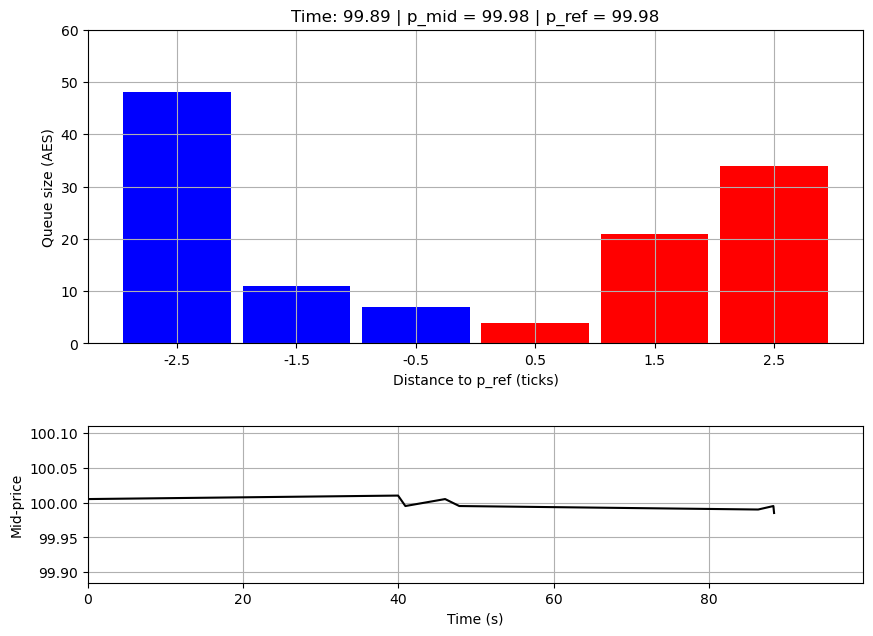

In [17]:
animate_lob(LOB, K=3, interval=30, filename="lob_animation.gif")

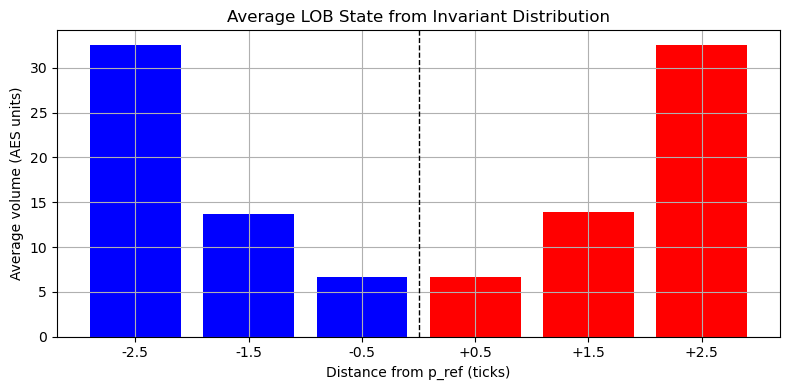

In [18]:
# Sample from invariant distribution
states = []
rng = np.random.default_rng(0)
for i in range(1000):
    state = sample_stationary_lob_from_file("invariant_distribution.npy", rng)
    states.append(state)

states = np.array(states)
mean_state = states.mean(axis=0)

# Bid is on left (reversed), ask is on right
# mean_state[:3] = q_bid3, q_bid2, q_bid1
# mean_state[3:] = q_ask1, q_ask2, q_ask3

# Reverse bid side so it's visually correct
copy_mean_state = np.concatenate([mean_state[:3][::-1], mean_state[3:]])

# x = distances from reference price: -2.5, -1.5, -0.5, +0.5, +1.5, +2.5
K = 3
x = [-(i - 0.5) for i in range(K, 0, -1)] + [(i - 0.5) for i in range(1, K + 1)]

plt.figure(figsize=(8, 4))
plt.bar(x, copy_mean_state, color=['blue']*K + ['red']*K)
plt.xticks(x, labels=[f"{v:+.1f}" for v in x])  # Show signed distances like -2.5, ..., +2.5
plt.axvline(0, color='black', linestyle='--', linewidth=1, label='p_ref')
plt.grid(True)
plt.xlabel("Distance from p_ref (ticks)")
plt.ylabel("Average volume (AES units)")
plt.title("Average LOB State from Invariant Distribution")
plt.tight_layout()
plt.show()